# The generalized linear model ###

#### Reference: 

http://statsthinking21.org

* The general linear model
* Comparing means

## Common statistical tests as linear models ##

Many statistical tests can be though of as implementations of the generalized linear model. Thinking of tests as part of a class of linear models can be more intuitive than thinking about how each test works individually.

### Resources

This approach is taken in Chapter 28 of *Statistical Thinking for the 21st Century* on comparing means:
* http://statsthinking21.org/comparing-means.html

A blog post by Jonas Kristoffer Lindeløv explains this approach for a wide array of statistical tests. Implementation of the statistical functions and linear models, with interpretations, are provided in both R and Python.
* Original post (using R): https://lindeloev.github.io/tests-as-linear/
* Python port: https://eigenfoo.xyz/tests-as-linear/

### Examples

The following examples show different ways of comparing means, using data from the 2007 West Coast Ocean Acidification cruise. The examples use quality controlled data from 0-10 dbar (upper 10m of the water column).

#### Comparing two sample means (another example)

The following shows the same calculations for temperature. In this case, the null hypothesis can be rejected at the 95% confidence level, and the 95% confidence intervals for the model slope do *not* overlap with zero.

Load 2007 data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.formula.api as smf
import pingouin as pg

import PyCO2SYS as pyco2

/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
filename07 = 'data/wcoa_cruise_2007/32WC20070511.exc.csv'
df07 = pd.read_csv(filename07,header=29,na_values=-999,parse_dates=[[6,7]])

Use the PyCO2SYS package to calculate seawater carbon chemistry parameters.

https://pyco2sys.readthedocs.io/en/latest/

In [3]:
c07 = pyco2.sys(df07['ALKALI'], df07['TCARBN'], 1, 2,
               salinity=df07['CTDSAL'], temperature=df07['CTDTMP'], 
                pressure=df07['CTDPRS'])

df07['OmegaA'] = c07['saturation_aragonite']

/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/PyCO2SYS/equilibria/p1atm.py:99: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/PyCO2SYS/equilibria/p1atm.py:577: RuntimeWarning: overflow encountered in power
  K1 = 10.0 ** -(pK1)
/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/PyCO2SYS/equilibria/p1atm.py:583: RuntimeWarning: overflow encountered in power
  K2 = 10.0 ** -(pK2)
/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/PyCO2SYS/equilibria/p1atm.py:603: RuntimeWarning: overflow encountered in power
  K1 = 10.0**-pK1
/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/P

#### Comparing two sample means (another example)

The following shows the same calculations for temperature. In this case, the null hypothesis can be rejected at the 95% confidence level, and the 95% confidence intervals for the model slope do *not* overlap with zero.

#### Comparing one sample mean to a single value

In this example the goal is to test whether the mean aragonite saturation state is different from a value of 1, a critical threshold for the ability of organisms to form calcium carbonate shells.

* $H_0$: $\bar{\Omega}_A =$ 1
* $H_A$: $\bar{\Omega}_A \neq$ 1 

The first step is to create a subset of good data from the upper 10m.

In [4]:
iisurf07 = ((df07['CTDPRS'] <= 10) &
      (df07['NITRAT_FLAG_W'] == 2) & (df07['PHSPHT_FLAG_W'] == 2)
      & (df07['CTDOXY_FLAG_W'] == 2) & (df07['CTDSAL_FLAG_W'] == 2) 
        & (df07['ALKALI_FLAG_W'] == 2) & (df07['TCARBN_FLAG_W'] == 2))

df07surf = df07[iisurf07]

A box plot is one way of showing the distribution of $\Omega_A$ values.
* Orange line: median, or 50th percentile
* Upper/lower limits on box: interquartile range, or 75th/25th percentiles
* Whiskers: each have length 1.5*interquartile range (pyplot default)
* Circles: extreme values
* Green triangle: mean
* Notches on box: 95% confidence intervals for median

Text(0.5, 1.0, '$\\Omega_A$ - upper 10m 2007')

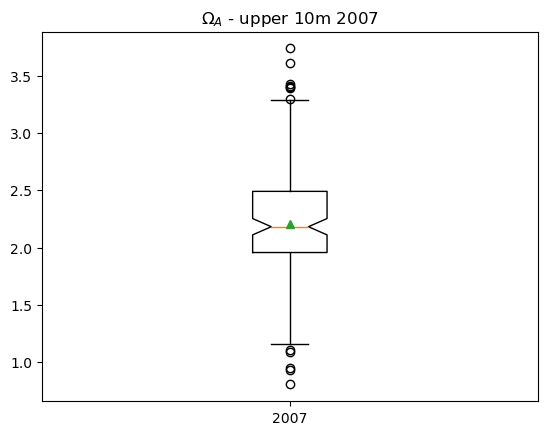

In [5]:
plt.figure()
plt.boxplot(np.array(df07['OmegaA'][iisurf07]),labels=['2007'],showmeans=True,notch=True);
plt.title('$\Omega_A$ - upper 10m 2007')

##### Method 1: one sample t-test

A one-sample t-test can be used to test whether the null hypothesis can be rejected at the 95% confidence level ($\alpha$ = 0.05). 

In [6]:
stats.ttest_1samp(np.array(df07surf['OmegaA']),popmean=1)

Ttest_1sampResult(statistic=27.74228835972303, pvalue=4.457126416644382e-58)

##### Method 2: generalized linear model

Alternatively, this test can be framed in terms of a general linear model

$$ \hat{y} = \hat{a}_1 + \hat{a}_2 x ,$$

In this application, $y$ represents the $\Omega_A$ data. There is only one group, so we can set $x = 0$ for all values, making the slope parameter $\hat{a}_2$ irrelevant. The model then reduces to

$$ \hat{y} = \hat{a}_1 ,$$

or a model for the intercept parameter only. This equation can also be expressed as

$$ \hat{y} = \hat{a}_1 \times 1.$$

This model for the data in terms of a constant intercept can be implemented with the `statsmodels` library:

In [7]:
res = smf.ols(formula="OmegaA ~ 1", data=df07surf).fit()

The summary of the results shows that the intercept is 2.33, which is also the mean of the data. The 95% confidence intervals do not overlap with 1, which means that the null hypothesis can be rejected at $\alpha$ = 0.05. This approach to hypothesis testing will give the same results as the one sample t-test for $N$ > 14.

Notice that the test statistic $t$ is different from the one sample t-test. This is because `statsmodels` automatically tests whether parameters are different from *zero*, while in this case we are interested in whether the mean/intercept is different from *one*.

In [8]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 OmegaA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 13 Jan 2025   Prob (F-statistic):                nan
Time:                        11:28:42   Log-Likelihood:                -102.08
No. Observations:                 138   AIC:                             206.2
Df Residuals:                     137   BIC:                             209.1
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2017      0.043     50.827      0.000       2.116       2.287
==============================================================================
Omnibus:                        7.228   Durbin-Watson:                   0.655
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               11.596
Skew:                           0.177   Prob(JB):                      0.00303
Kurtosis:                       4.375   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparing two sample means

We can also apply the generalized linear model approach when comparing two means. In this case, we will examine whether there is a statistically significant difference between the mean of $\Omega_A$ to the north and south of Cape Mendocino. At a latitude of 40.4$^o$N, Cape Mendocino represents a sharp transition point in many oceanographic processes and water masses.

The first steps are to make two subsets based on latitude, and then visualize the results in a box plot.

In [9]:
# create a new boolean variable in the df07surf dataframe
df07surf = df07[iisurf07]
df07surf = df07surf.assign(is_northern = df07surf['LATITUDE'] > 40.4);

iinorth = np.array(df07surf.is_northern == True)
iisouth = np.array(df07surf.is_northern == False)

Text(0.5, 1.0, '$\\Omega_A$ - upper 10m 2007')

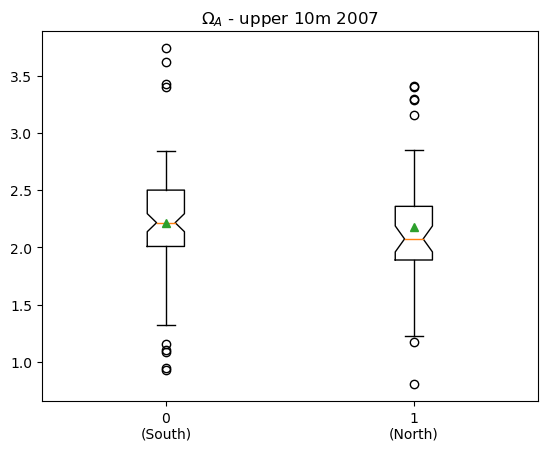

In [10]:
plt.figure()
plt.boxplot([df07surf['OmegaA'][iisouth],df07surf['OmegaA'][iinorth]],
            labels=['0\n(South)','1\n(North)'],showmeans=True,notch=True)
plt.title('$\Omega_A$ - upper 10m 2007')

##### Method 1: t-test

There is a difference of 0.104 in the mean of $\Omega_A$ between the two regions.

In [11]:
np.mean(df07surf['OmegaA'][iinorth]) - np.mean(df07surf['OmegaA'][iisouth])

-0.03056105006487364

Is this difference statistically significant? A Student's t-test can be used to test whether the null hypothesis of no difference can be rejected at the 95% confidence level. 

In [12]:
stats.ttest_ind(df07surf['OmegaA'][iinorth],df07surf['OmegaA'][iisouth],equal_var=True)

Ttest_indResult(statistic=-0.3235609219137568, pvalue=0.7467674907175257)

A Welch's t-test relaxes the assumption of equal variance.

In [13]:
stats.ttest_ind(df07surf['OmegaA'][iinorth],df07surf['OmegaA'][iisouth],equal_var=False)

Ttest_indResult(statistic=-0.30410900939221397, pvalue=0.7619693293723315)

##### Method 2: generalized linear model

This test can also be framed in terms of a general linear model

$$ \hat{y} = \hat{a}_1 + \hat{a}_2 x .$$

Again, $\hat{y}$ is a model for the aragonite saturation state data. In this case, we can think of the southern data points as having $x = 0$ and the northern data points as having $x = 1$.

In this model, the intercept parameter $\hat{a}_1$ is the mean of the points with $x = 0$, the southern points.

The slope parameter $\hat{a}_2$ is equal to the difference between the means of the two groups.

$$ slope = \frac{\Delta\bar{y}}{\Delta x} = \frac{\Delta\bar{y}}{1} = \Delta\bar{y}$$ 

In [14]:
res = smf.ols(formula="OmegaA ~ is_northern", data=df07surf).fit()

The results are summarized below. The slope parameter $\hat{a}_2$ in our model is the coefficient for the `is_northern` variable. This is a Boolean variable that is equal to 0 (`False`) for southern points and 1 (`True`) for northern points. Notice that this coefficient is equal to 0.104, which the same as the difference between the two means.

Also notice that the 95% confidence intervals (shown as the `[0.025 0.975]` interval) overlap 0 for this parameter. This means that the difference is not statistically significant at the 95% confidence ($\alpha$ = 0.05) level. This summary also shows a t-statistic and p-value for this parameter, which are equivalent to the Student's t-test result shown above.

In [15]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 OmegaA   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1047
Date:                Mon, 13 Jan 2025   Prob (F-statistic):              0.747
Time:                        11:28:43   Log-Likelihood:                -102.03
No. Observations:                 138   AIC:                             208.1
Df Residuals:                     136   BIC:                             213.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2110      0.052     42.433      0.000       2.108       2.314
is_northern[T.True]    -0.0306      0.094     -0.324      0.747      -0.217       0.156
==============================================================================
Omnibus:                        7.460   Durbin-Watson:                   0.655
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               12.047
Skew:                           0.189   Prob(JB):                      0.00242
Kurtosis:                       4.397   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparing two sample means (another example)

The following shows the same calculations for temperature. In this case, the null hypothesis can be rejected at the 95% confidence level, and the 95% confidence intervals for the model slope do *not* overlap with zero.

Text(0.5, 1.0, 'CTDTMP - upper 10m 2007')

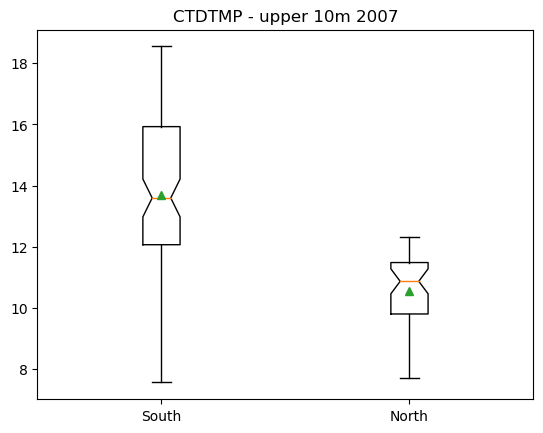

In [16]:
plt.figure()
plt.boxplot([df07surf['CTDTMP'][iisouth],df07surf['CTDTMP'][iinorth]],
            labels=['South','North'],showmeans=True,notch=True);
plt.title('CTDTMP - upper 10m 2007')

In [17]:
stats.ttest_ind(df07surf['CTDTMP'][iinorth],df07surf['CTDTMP'][iisouth],equal_var=True)

Ttest_indResult(statistic=-7.375689840798797, pvalue=1.4522086213500351e-11)

In [18]:
stats.ttest_ind(df07surf['CTDTMP'][iinorth],df07surf['CTDTMP'][iisouth],equal_var=False)

Ttest_indResult(statistic=-9.799130523807385, pvalue=1.7823812194777297e-17)

In [19]:
res = smf.ols(formula="CTDTMP ~ is_northern", data=df07surf).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CTDTMP   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     54.40
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           1.45e-11
Time:                        11:28:43   Log-Likelihood:                -310.63
No. Observations:                 138   AIC:                             625.3
Df Residuals:                     136   BIC:                             631.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.6931      0.236     57.959      0.000      13.226      14.160
is_northern[T.True]    -3.1587      0.428     -7.376      0.000      -4.006      -2.312
==============================================================================
Omnibus:                        4.510   Durbin-Watson:                   0.191
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.064
Skew:                          -0.408   Prob(JB):                        0.131
Kurtosis:                       3.202   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparing three sample means (another example)

We can also compare more than two means. This would be an ANOVA analysis, which can also be expessed as a linear model.

##### Create a categorical variable for the region

We will divide the data into three categories: north if the Columbia River, between the Columbia River and Golden Gate, and south of the Golden Gate.

In [20]:
# create a new variable called "region" with no values
df07surf = df07surf.assign(region = [None]*len(df07surf))
df07surf['region']

22      None
46      None
71      None
95      None
151     None
        ... 
2275    None
2287    None
2310    None
2334    None
2335    None
Name: region, Length: 138, dtype: object

In [21]:
# assign string values to region based on latitude
northern = (df07surf['LATITUDE'] > 46.2)
central = (df07surf['LATITUDE'] <= 46.2) & (df07surf['LATITUDE'] >= 37.8)
southern = (df07surf['LATITUDE'] < 37.8) 

df07surf.loc[northern,'region'] = 'north'
df07surf.loc[central,'region'] = 'central'
df07surf.loc[southern,'region'] = 'south'
df07surf['region']

22      north
46      north
71      north
95      north
151     north
        ...  
2275    south
2287    south
2310    south
2334    south
2335    south
Name: region, Length: 138, dtype: object

##### Box plot

Text(0.5, 0, 'region')

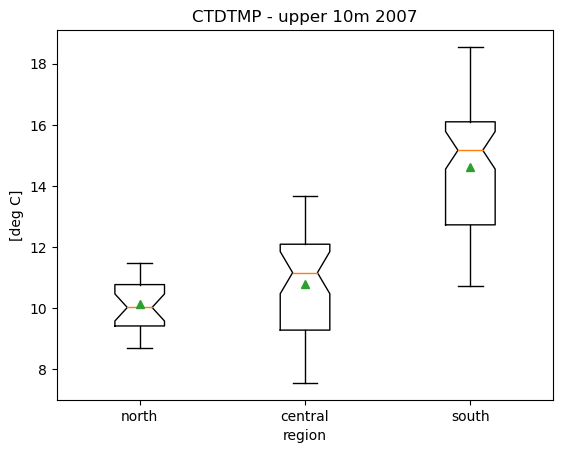

In [22]:
plt.figure()
plt.boxplot([df07surf['CTDTMP'][df07surf['region']=='north'],
             df07surf['CTDTMP'][df07surf['region']=='central'],
             df07surf['CTDTMP'][df07surf['region']=='south']],
            labels=['north','central','south'],showmeans=True,notch=True);
plt.title('CTDTMP - upper 10m 2007')
plt.ylabel('[deg C]')
plt.xlabel('region')

##### Analysis

Since we have three groups, we can perform a classic Fisher ANOVA on this data set, to test the null hypothesis of no difference.

In [23]:
pg.anova(data=df07surf,dv='CTDTMP',between='region')

,Source,ddof1,ddof2,F,p-unc,np2
0,region,2,135,86.688737,6.087664e-25,0.562225


However, looking at the box plot, it appears that the groups do not have equal variances (heteroscedesticity). This suggests that a Welch ANOVA may be more appropriate.

In [24]:
pg.welch_anova(data=df07surf,dv='CTDTMP',between='region')

,Source,ddof1,ddof2,F,p-unc,np2
0,region,2,79.857577,117.8407,1.489427e-24,0.562225


Both have very low p-values. Now we move on to a post-hoc test. Which post-hoc test to use? The Tukey test is a good choice for the classic ANOVA because it corrects for pairwise comparisons. However, it assumes equal variances. A Games-Howell post-hoc test is preferable in this case.

In [25]:
pg.pairwise_gameshowell(data=df07surf,dv='CTDTMP',between='region')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,central,north,10.791951,10.124478,0.667473,0.320915,2.079905,60.998772,1.024835e-01,0.535267
1,central,south,10.791951,14.616919,-3.824968,0.361271,-10.587518,95.679603,2.531308e-14,-2.047561
2,north,south,10.124478,14.616919,-4.492441,0.296634,-15.144727,88.746057,2.720046e-14,-3.586874


The p-values indicate that there is no statistically significant difference between the northern and central regions.

Ho does this compare to pairwise t-tests? The t-test indicates that there is a statistically significant difference (barely) at $\alpha$=0.05 between the northern and central regions.

In [26]:
pg.pairwise_ttests(data=df07surf,dv='CTDTMP',between='region')

/Users/tconnolly/opt/miniconda3/envs/data-book/lib/python3.10/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,region,central,north,False,True,2.079905,60.998772,two-sided,4.174356e-02,1.575,0.447480
1,region,central,south,False,True,-10.587518,95.679603,two-sided,8.500978e-18,2.726e+15,-1.944715
2,region,north,south,False,True,-15.144727,88.746057,two-sided,2.478834e-26,4.026e+23,-2.401071


We can also use statsmodels to perform this test as a linear model. Note that the F-statistic and Prob (F-statistic), a.k.a. p-value, are the same as the classic ANOVA.

The regression coefficients in this case can be thought of as pairwise comparisons with the central region. Note that the confidence intervals of the regression coefficient with the north region overlap with zero.

In [27]:
pg.homoscedasticity(data=df07surf,dv='CTDTMP',group='region')

,W,pval,equal_var
levene,9.765584,0.000109,False


In [28]:
res = smf.ols(formula="CTDTMP ~ region", data=df07surf).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CTDTMP   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     86.69
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           6.09e-25
Time:                        11:28:43   Log-Likelihood:                -276.85
No. Observations:                 138   AIC:                             559.7
Df Residuals:                     135   BIC:                             568.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.7920      0.284     37.991      0.000      10.230      11.354
region[T.north]    -0.6675      0.474     -1.409      0.161      -1.605       0.270
region[T.south]     3.8250      0.354     10.801      0.000       3.125       4.525
==============================================================================
Omnibus:                        8.796   Durbin-Watson:                   0.310
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                4.392
Skew:                          -0.204   Prob(JB):                        0.111
Kurtosis:                       2.227   Cond. No.                         4.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""